# Improving Embeddings with Biased Random Walks in Node2Vec

## Different Dataset Creation Algorithm
Here we use biased random walks, where we use a combination of bfs and dfs, and also use the term neighbourhood, homophily and Structural Equivalence. 

In Node2Vec, our goal is to bias the randomness of these walks to either one of the following:

- Promoting nodes that are not connected to the previous one (similar to DFS)
- Promoting nodes that are close to the previous one (similar to BFS)


!<img src="images/transition_graph.png">

Let's take **Figure 4.2** as an example. The current node is called $j$, the previous node is $i$, and the future node is $k$. We note $\pi_{jk}$, the unnormalized transition probability from node $j$ to node $k$. This probability can be decomposed as:

$$
\pi_{jk} = \alpha(i,k) \cdot \omega_{jk}
$$

where $\alpha(i,k)$ is the **search bias** between nodes $i$ and $k$, and $\omega_{jk}$ is the weight of the edge from $j$ to $k$.

---

In **DeepWalk**, we have:

$$
\alpha(a,b) = 1
$$

for any pair of nodes $a$ and $b$.

In **Node2Vec**, the value of $\alpha(a,b)$ is defined based on the distance between the nodes and two additional parameters: $p$, the return parameter, and $q$, the in-out parameter. Their role is to approximate **DFS** and **BFS**, respectively.

Here is how the value of $\alpha(a,b)$ is defined:

$$
\alpha(a,b) =
\begin{cases}
\frac{1}{p} & \text{if } d_{ab} = 0 \\
1 & \text{if } d_{ab} = 1 \\
\frac{1}{q} & \text{if } d_{ab} = 2
\end{cases}
$$

Here, $d_{ab}$ is the shortest path distance between nodes $a$ and $b$. We can update the unnormalized transition probability from the previous graph as follows:

---

Let's decrypt these probabilities:

- The walk starts from node $i$ and now arrives at node $j$. The probability of going back to the previous node $i$ is controlled by the parameter $p$. The higher it is, the more the random walk will explore new nodes instead of repeating the same ones and looking like **DFS**.

- The unnormalized probability of going to $k_1$ is $1$ because this node is in the immediate neighborhood of our previous node, $i$.

- Finally, the probability of going to node $k_2$ is controlled by the parameter $q$. The higher it is, the more the random walk will focus on nodes that are close to the previous one and look like **BFS**.


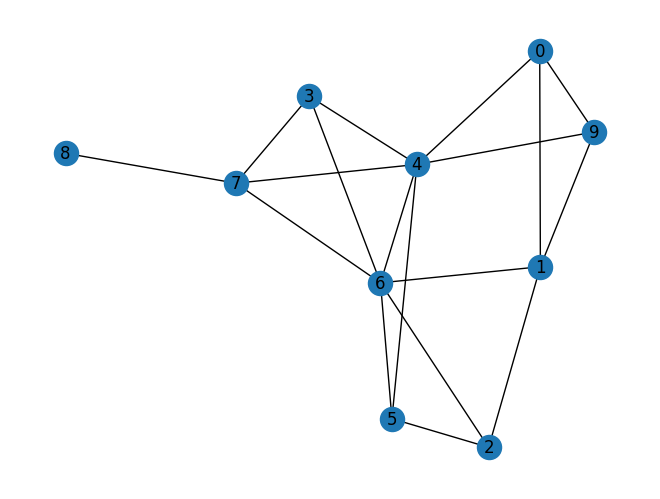

In [7]:
import networkx as nx
import random
random.seed(0)
import numpy as np
np.random.seed(0)
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)
nx.draw(G, with_labels=True)

In [11]:
def next_node(previous, current, p, q):
    neighbors = list(G.neighbors(current))
    alphas = []
    for neighbor in neighbors:
        if neighbor == previous:
            alphas.append(1 / p)
        elif G.has_edge(neighbor, previous):
             alphas.append(1)
        else:
            alphas.append(1 / q)
    probs = [alpha / sum(alphas) for alpha in alphas]
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [12]:
# the walks are defined as in Chapter 3.ipynb just here we add new wit next_node()
def random_walk(start, length, p, q):
    walk = [start]
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    return [str(x) for x in walk]

In [13]:
# Now make one random and one biased
print(f'Unbiased Random Walk\t p = q = 1:\n{random_walk(0, 8, p=1, q=1)}')
print(f'Biased Random Walk\t p = 1, q = 10:\n{random_walk(0, 8, p=1, q=10)}')
print(f'Biased Random Walk\t p = 10, q = 1:\n{random_walk(0, 8, p=10, q=1)}')


Unbiased Random Walk	 p = q = 1:
['0', '9', '4', '5', '6', '1', '6', '1', '9']
Biased Random Walk	 p = 1, q = 10:
['0', '4', '0', '4', '9', '0', '4', '0', '9']
Biased Random Walk	 p = 10, q = 1:
['0', '4', '7', '8', '7', '4', '5', '6', '1']


# Implementing Node2Vec

In [15]:
# Exactly the same code with Chapter 3.ipynb only the implementation of random_walk changed
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
G = nx.karate_club_graph()
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))
node2vec = Word2Vec(walks,
                hs=1,   # Hierarchical softmax
                sg=1,   # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                min_count=1,
                seed=0)
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
train_mask_str = [str(x) for x in train_mask]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_mask_str = [str(x) for x in test_mask]
labels = np.array(labels)
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask_str], labels[train_mask])
y_pred = clf.predict(node2vec.wv[test_mask_str])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 95.45%


The concepts of **homophily** and **structural equivalence** are key to understanding why **DFS** (Depth-First Search) is better suited for capturing **homophilic** properties and **BFS** (Breadth-First Search) is better at emphasizing **structural equivalence**.

### Homophily vs. Structural Equivalence

1. **Homophily** refers to the tendency of similar nodes to be connected. In social networks, for example, this means that people with similar interests, backgrounds, or characteristics tend to form connections. In graph representation learning, we want to capture this local, close-neighbor similarity.

2. **Structural Equivalence**, on the other hand, refers to nodes that occupy similar positions in the graph, even if they are not directly connected. For example, two managers in different departments of a company may not be directly connected but occupy equivalent positions in their respective networks. Capturing structural equivalence is about identifying similar roles or patterns in the network structure, regardless of the direct connections between nodes.

### Why DFS Better Captures Homophily

**DFS (Depth-First Search)** explores paths deeply, meaning it tends to travel along edges until it reaches a dead-end before backtracking. This behavior tends to emphasize **local structures** because:

- **DFS "dives" into the graph:** When a DFS explores a node, it continues moving to adjacent nodes (neighbors) along a path until it reaches a node with no unvisited neighbors. In a homophilic graph, nodes that are connected along a deep path are likely to be similar in nature (due to homophily). Therefore, DFS captures nodes that are close in terms of both **distance** and **similarity**.
  
- **Capturing clusters:** Since homophily often leads to the formation of **local clusters** of similar nodes, DFS naturally focuses on these local regions of the graph. By exploring deep paths, DFS tends to stay within these clusters before backtracking. This means that embeddings generated from a DFS-based random walk will emphasize these **local clusters** of similar nodes, which is essential for representing homophily.

### Why BFS Better Captures Structural Equivalence

**BFS (Breadth-First Search)** explores all nodes at the current depth level before moving deeper. This strategy emphasizes **nodes that are at the same distance from the starting point**, which is important for capturing **structural equivalence** because:

- **BFS explores across "roles":** Instead of exploring deeply into local neighborhoods, BFS moves outward evenly from the starting node. This means BFS examines all nodes at the same level of connectivity first (e.g., all direct neighbors, then their neighbors, and so on). Nodes at the same distance from a given node are often **structurally equivalent**, even if they aren’t directly connected.

- **Focus on global graph roles:** Nodes that are structurally equivalent may not have direct links, but they play similar roles in different parts of the graph (e.g., nodes at the same depth in different branches of the graph). By focusing on nodes that are at the same distance, BFS can capture **functional similarity** or **positional roles** within the graph, which is key for structural equivalence.

### Summary

- **DFS favors homophily** because it explores local paths deeply, staying within clusters of similar nodes. This results in embeddings that emphasize **local similarity**.
  
- **BFS favors structural equivalence** because it explores nodes layer by layer, focusing on nodes that are the same distance from a starting point. This results in embeddings that highlight **similar roles or positions** in the overall graph structure, regardless of direct connections.

### Application in Node2Vec

In **Node2Vec**, the **p** and **q** parameters allow for a **trade-off** between DFS-like and BFS-like behaviors during random walks:

- A higher **p** encourages the random walk to return to the previous node, which makes the walk behave more like DFS, focusing on **local clusters** and capturing **homophily**.
- A higher **q** encourages the random walk to move outward to a different part of the graph, behaving more like BFS and emphasizing **structural equivalence**.

By adjusting these parameters, Node2Vec can learn embeddings that capture either local similarity (homophily) or global graph roles (structural equivalence), depending on the task.

# The Karate case
This project dataset is by itself homophilic so we would expect for 
- dfs to be able to understand the representation better since it better captures nodes deeper connections with each other (as are the friends of friends of friends here)
- bfs is better able to understand more surface related info for nodes (like grouping them according to the number of friends)

!<img src="images/pq_karate_node2vec.png">

---
# Building a move RecSys

To create the dataset check the movies that are liked and the ones that are not and create the vectors for them.

In [17]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [18]:
import pandas as pd

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [19]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [20]:
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [25]:
from collections import defaultdict

pairs = defaultdict(int)

# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [26]:
# Create a networkx graph
G = nx.Graph()

# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


In [27]:
# !pip install node2vec

In [28]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:36<00:00,  5.54it/s]


In [29]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Raiders of the Lost Ark (1981): 0.57
Return of the Jedi (1983): 0.55
Restoration (1995): 0.51
Godfather, The (1972): 0.49
Monty Python and the Holy Grail (1974): 0.47
